# **DML 성능 영향 요소**

- 기본적인 DML 튜닝을 설명하기 전 DML 성능에 영향을 미치는 요소에 대해 설명.
- 인덱스
  - 인덱스를 위한 데이터를 생성하거나 삭제하는 작업은 DML 성능에 영향을 준다.
  - INSERT, DELETE는 인덱스 조작을 한 번만 수행한다.
  - UPDATE는 인덱스 조작을 두 번 수행한다. (DELETE, INSERT)
  - 시스템마다 다르지만
    - 인덱스 1개에 100만 건 데이터를 넣을 때는 5초
    - 인덱스 3개에 100만 건 데이터를 넣을 때는 40초

- 무결성 제약
  - PK, FK, Check, Not Null 같은 제약도 DML 성능에 영향을 미친다.
  - 시스템마다 다르지만
    - PK가 없으면 100만건 데이터를 넣을 때는 1.3초
    - PK가 있으면 100만건 데이터를 넣을 때는 4.95초

- 조건절
  - 조건절을 확인하기 위하여 SELECT를 한다.
  - 따라서 SELECT 할 때와 동일하게 인덱스를 잘 활용해서 DML을 수행해야 한다.

- 서브 쿼리
  - 조건절과 마찬가지로 SELECT 할 때와 동일하게 인덱스를 잘 활용해서 DML을 수행해야 한다.

- Redo 로깅
  - Redo : 모든 변경 사항을 기록하는 로그이다.
    - 물리적으로 디스크가 깨질 경우, 데이터베이스를 복구하기 위해 사용
    - 정전 등으로 버퍼 캐시가 사라질 경우, 캐시를 복구하기 위해 사용
    - 커밋은 느리므로 혹시 모를 상황을 대비해 트랜잭션에 의한 변경사항을 저장해놓는다.
  - DML을 수행할 때마다 로그를 쌓으므로 성능에 영향을 미친다.


- Undo 로깅
  - Undo : 오라클 9i부터 Rollback을 Undo로 표현
  - 변경된 블록을 이전 상태로 되돌리는 데 필요한 정보를 로깅해야 하므로 성능에 영향을 미친다.

- Lock
  - Lock은 DML 성능에 아주 큰 영향을 주는 요소이다.
  - 길게 잡으면 DML 성능이 안 좋아지고, 짧게 잡으면 데이터 품질이 안 좋아진다.

- 커밋
  - Lock과 함께 커밋도 DML 성능에 간접적으로 영향을 미친다.
  - 커밋의 내부 메커니즘은 다음과 같다.
    - DML문을 수행하면 버퍼 캐시가 정전 등으로 사라질 수 있으므로 Redo 로깅을 먼저 해놓는다.
    - Redo 로그 파일에 기록하기 전에 파일 자체도 I/O이므로 느리다. 따라서 로그 버퍼에 변경사항을 먼저 기록한다.  
    - 버퍼 캐시에 변경된 블록을 기록한다.
    - 커밋을 하게 되면
    - LGWR 프로세스가 Redo 로그 버퍼 내용을 Redo 로그 파일에 일괄 저장한다.
    - DBWR 프로세스가 버퍼 캐시에 변경된 블록을 데이터 파일에 일괄 저장한다.

# **기본 DML 튜닝**

- DB는 SQL을 수행하면 Parse, Execute, Fetch Call이 발생한다.
  - Parse Call : 1.1장에서 설명한 파싱과 최적화를 수행하는 단계이다.
  - Execute Call : 실제로 SQL을 실행하는 단계이다. DML일 경우 해당 단계에서 마무리된다.
  - Fetch Call : SELECT문에서 사용자에게 결과를 전송하는 단계이다. 전송할 데이터가 많다면 여러 번 호출된다.


- Call은 발생 위치에 따라 User, Recursive Call로 나뉜다.
  - User Call : DBMS 외부로부터 인입되는 Call. WAS가 앞단에 있다면 WAS가 DBMS를 호출할 때 발생한다.
  - Recursive Call : DBMS 내부에서 발생하는 Call. 함수/프러시저/트리거에 내장된 SQL을 실행할 때 발생한다.


- Call은 성능에 영향을 주며, 네트워크를 경유하는 User Call이 성능에 미치는 영향이 크다.
  - 100만 건 기준으로 Recurisive Call만 발생하는 for문의 insert문을 짠 PL/SQL은 30초 걸림
  - User Call (자바로 짠 코드)는 220초 걸림
  - 하나의 SQL인 Insert Into Select은 한번의 Call만 발생하므로 1.4초 걸린다. 따라서 ONE SQL을 최대한 사용하는 것이 좋다.


- One SQL로 작성하기 힘들 때는 Array Processing을 활용
  - 100만 건 기준으로 Recurisive Call만 발생하는 for문의 insert문을 짠 PL/SQL 4초
  - User Call (자바로 짠 코드)는 12초



```java
for(int i = 0 ; i < length; i++){
	...
	st.addBatch();
}

st.executeBatch();​​
```
<br>

- 인덱스 및 제약 해제를 통한 대량 DML 튜닝
  - 인덱스와 무결성 제약은 DML 성능에 영향을 주는 요소이다.
  - 1000만 건의 데이터를 입력하게 되면
    - PK 인덱스 + 일반 인덱스 존재 : 약 1분 19초
    - 인덱스 및 제약사항이 없을 경우  :  약 5.8초
  - 애플리케이션이 실행 중에 자주 발생하는 테이블에 대한 인덱스 및 제약을 잠시 동안 해제하기는 어렵다.
  - 대량 데이터를 적재하기 위한 배치 프로그램에서는 이들 기능을 해제함으로써 DML 성능을 크게 높일 수 있다.
  - 해당 DML이 테이블의 데이터를 5% 이상 수정할 경우 사용하는 것을 추천한다.

```sql
-- PK 제약사항 및 PK 인덱스 드랍
ALTER TABLE 테이블 MODIFY CONSTRAINT PK명 DISABLE DROP INDEX;

-- 일반 인덱스 비활성화
ALTER INDEX 인덱스명 UNUSABLE;

-- PK 제약사항 및 PK 인덱스 재생성
ALTER TABLE 테이블 MODIFY CONSTRAINT PK명 ENABLE NOVALIDATE;

-- 일반 인덱스 활성화
ALTER INDEX 인덱스명 REBUILD;
```
 <br>
- 뷰 : 하나 이상의 테이블이나 다른 뷰의 데이터를 볼 수 있게 하는 데이터베이스 객체. 실제 데이터는 뷰를 구성하는 테이블에 담겨 있지만 마치 테이블처럼 사용할 수 있다.
- 조인 뷰 : FROM 절에 두 개 이상의 테이블을 가진 뷰

```sql
CREATE OR REPLACE VIEW EMP_DEPT_VIEW AS
	SELECT
		E.ROWID AS EMP_RID
		,E.*
		,D.ROW_ID AS DEPT_RID
		,D.DNAME
		,D.LOC
	FROM EMP E, DEPT D
	WHERE E.DEPTNO = D.DEPTNO;
```

<br>
- 수정 가능 조인 뷰 : 입력, 수정, 삭제가 허용되는 조인 뷰이다. 키 보존 테이블 설정을 해야만 가능하다.

```sql
-- 연봉이 1500 이하인 직원의 휴대폰번호를 '1234'로 변경
-- 하지만 현 상태에서는 ORA-01779 라는 에러가 발생한다.
-- ORA-01779는 키-보존 테이블을 알 수 없어 발생하는 에러이다.
UPDATE EMP_DEPT_VIEW SET EMP_PHONE = '1234' WHERE SAL <= 1500;
```

# **Direct Path I/O 활용**

- 버퍼 캐시의 장점
  - 일반적으로 SQL문을 실행하면 1장에서 설명한 버퍼 캐시를 확인해보고 작업을 진행한다.
  - 반복적으로 동일한 블록을 찾는 경우에 버퍼 캐시는 성능을 높여주는 아주 좋은 기능이다.

- 버퍼 캐시의 단점
  - 버퍼 캐시를 탐색하는 것도 락에 의해서 느릴 수 있다.
  - 반복적으로 동일한 블록을 찾을 경우가 없을 경우에는 오히려 버퍼 캐시를 한번 찾아보는 행위는 성능에 나쁜 영향을 미친다.


- 오라클은 버퍼 캐시를 사용할 필요가 없을 경우를 위해 버퍼 캐시를 경유하지 않고 곧바로 데이터 블록을 읽고 쓸 수 있는 Direct Path I/O 기능을 제공한다.
- 버퍼 캐시가 동작하도록 할 수 있는 방법에는 총 6가지가 존재한다.


1. Direct Path Insert를 수행할 때
- 일반적인 Insert와 Direct Path Insert의 순서는 다음과 같다.

|순서|일반적인 Insert|Direct Path Insert|
|--|--|--|
|1|	FreeList에서 데이터를 입력할 수 있는 블록을 찾음|FreeList를 찾아보지 않고, 맨 뒤에 순차적으로 쌓는다.|
|2|FreeList에서 할당받은 블록을 버퍼 캐시에서 찾음|블록을 버퍼 캐시에서 탐색하지 않는다.|
|3|버퍼 캐시에 없으면 데이터 파일에서 읽어 버퍼 캐시에 적재한다.|버퍼 캐시에 적재하지 않고, 데이터 파일에 직접 기록한다.|
|4|Undo 기록|Undo 기록하지 않음|
|5|Redo 기록|Redo를 하지 않도록 할 수 있음|

- 버퍼 캐시를 참조하지 않고, Undo, Redo를 로깅하지 않을 수 있어 매우 빠르다.


- Direct Path Insert를 유도할 수 있는 방법은 네 가지가 존재한다.
  - INSERT /*+ append */ INTO SELECT ... 처럼 append 힌트로 유도한 경우
  - INSERT /*+ parallel(C 4) */ INTO 고객 C 처럼 parallel 힌트로 유도한 경우
  - CREATE TABLE ... AS SELECT 문을 사용할 경우
  - 데이터를 적재할 수 있는 툴인 SQL*LOADER를 사용할 때 direct 옵션을 true로 준 경우


- Direct Path Insert를 사용할 때 주의할 점은 두 가지가 존재한다.
  - Exclusive 모드 TM Lock이 걸려 다른 트랜잭션은 해당 테이블에 DML을 수행할 수 없다. 따라서 해당 테이블에 대해 DML 수행이 없을 때 작업을 진행해야 한다.
  - FreeList 참조하면 삭제된 여유공간을 재활용할 수 있지만, Direct Path Insert는 항상 맨 뒤에 Insert를 하므로 사이즈가 줄지 않고 계속 늘어난다.




2. 병렬 DML을 수행할 때

- Direct Path Insert를 INSERT에서 사용하는 방법이므로 UPDATE와 DELETE는 사용할 수 없다.
- 병렬 DML로 UPDATE와 DELETE를 수행할 경우 Direct Path Insert 방식을 사용할 수 있다.


- 병렬 DML을 사용하기 위해서는 아래와 같이 병렬 DML을 활성화해야 한다.

```sql
ALTER SESSION SET ENABLE PARALLEL DML;​
```
<br>
- parallel 힌트를 사용하여 병렬 DML을 사용하면 된다.

```sql
UPDATE /*+ full(c) parallel(c 4) */ 고객 c ㄴㄸㅆ 고객상태 = '휴먼'
WHERE 최종거래일시 < '20200101';

DELETE /*+ full(c) parallel(c 4) */ FROM 고객 c
WHERE 탈퇴일시 < '20200101';​
```
<br>
- 병렬 DML을 수행할 경우 Direct Path Insert 단점과 동일하게 Exclusive 모드 TM Lock이 걸리므로 잘 사용해야 한다.




3. parallel 또는 parallel_index 힌트를 사용하여 병렬 쿼리로 Full Scan을 수행할 때

- 병렬 DML처럼 SELECT를 병렬 쿼리로 Full Scan 할 경우 발생
```sql
SELECT /*+ full(t) parallel(C 4) */ * FROM 고객 C;​
```
<br>
4. Temp 세그먼트 블록들을 읽고 쓸 때



5. direct 옵션을 true로 활성화하고 export 할 때



6. nocache 옵션을 지정한 LOB 컬럼을 읽을


# **파티션을 활용한 DML 튜닝**

- 파티셔닝 : 테이블 또는 인덱스 데이터를 특정 컬럼 값에 따라 별도 세그먼트에 나눠서 저장하는 것
  - 관리적 측면 : 파티션 단위 백업, 추가, 삭제, 변경 → 가용성 향상
  - 성능적 측면 : 파티션 단위 조회 및 DML, 경합 또는 부하분산


- 파티션에는 Range, 리스트, 해시 방식이 있다.
  - Range 방식: 값의 범위에 따라 파티셔닝

```sql
create table ...

partition by range(주문일자) (
	partition P2017_Q1 values less than ('20170401')
	, partition P2017_Q2 values less than ('20170701')
	, partition P2017_Q3 values less than ('20170101')
	, partition P2017_Q4 values less than ('20180101')
	, partition P2018_Q1 values less than ('20180401')
	, partition P9999_MX values less than (MAXVALUE)
);
```
<br>

  - Hash 방식 : 파티션 키 값을 해시 함수에 입력. 파티션 개수를 사용자가 결정

```sql
create table ...

partition by hash(고객ID) partitions 4;​
```

<br>

- List 방식 : 그룹핑 기준에 따라 데이터를 분할 저장하는 방식

```sql
create table ...

partition by list(지역분류) (
	partition P_지역1 values ('서울')
	, partition P_지역2 values ('경기', '인천')
	, partition P_기타 values (DEFALUT)
);
```

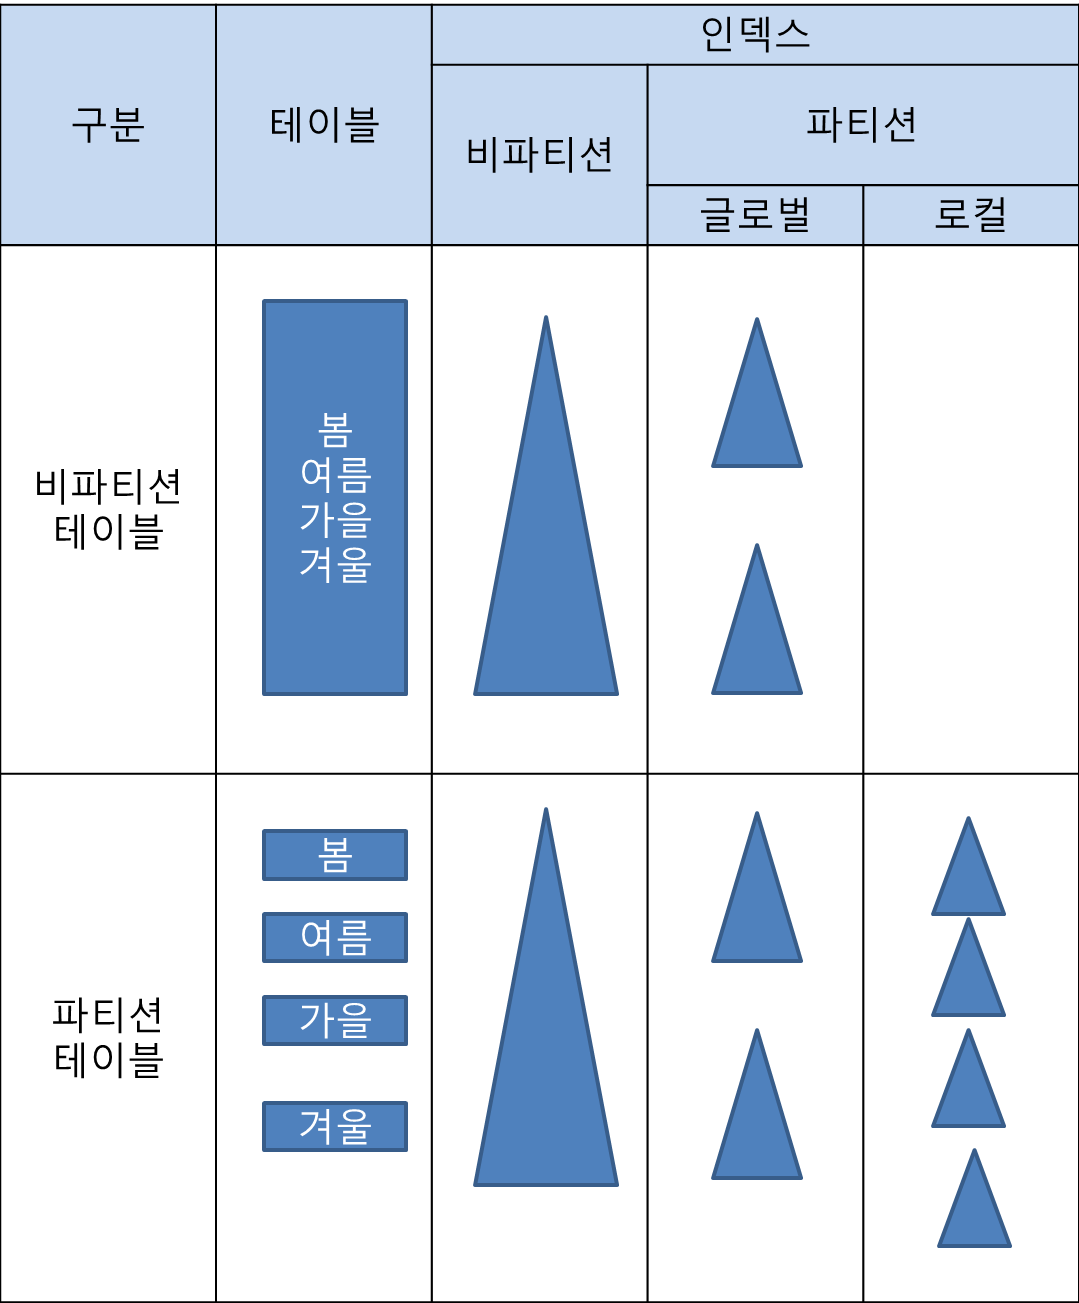

- 테이블 파티션 : 테이블을 파티셔닝
  - 비 파티션 테이블 : 파티셔닝 하지 않은 테이블로 일반적인 테이블이다.
  - 파티션 테이블 : 파티셔닝 한 테이블


- 인덱스 파티션 : 인덱스를 파티셔닝. 테이블 파티션과 인덱스 파티션을 혼동하지 말자.
  - 비 파티션 인덱스
    - 파티셔닝 하지 않은 인덱스로 일반적인 인덱스이다.
    - 만약 파티션 된 테이블의 파티션 구성을 변경하게 되면 비 파티션 인덱스는 재생성되어야 하며 그동안 서비스가 중단되므로 조심해야 한다.
    - 아래는 파티션 테이블일 때 비 파티션 인덱스의 예시이다.

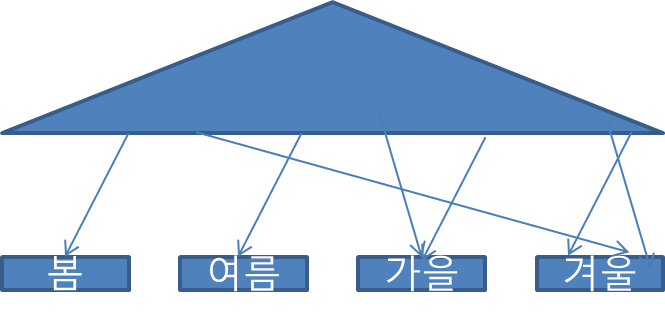

- 로컬 파티션 인덱스

```sql
-- 인덱스 생성문 마지막에 LOCAL 옵션을 주면 로컬 인덱스로 생성된다.
create index ... LOCAL;
```


  - 테이블 파티션과 1:1로 매핑되는 인덱스 파티션. 즉 테이블 파티션 개수만큼 인덱스 파티션이 존재함.
  - 테이블 파티션의 키가 동일하게 로컬 인덱스에 상속된다. 따라서 테이블 파티션의 키와 인덱스 파티션의 키는 동일하다.
  - 테이블 파티션의 키가 '계절'이라면 인덱스 파티션의 키도 '계절'이다.
  - 오라클에서 관리해주므로 테이블 파티션 구성을 변경하더라도 서비스에 영향을 거의 주지 않음
  - 아래는 파티션 테이블일 때 로컬 인덱스의 예시이다.

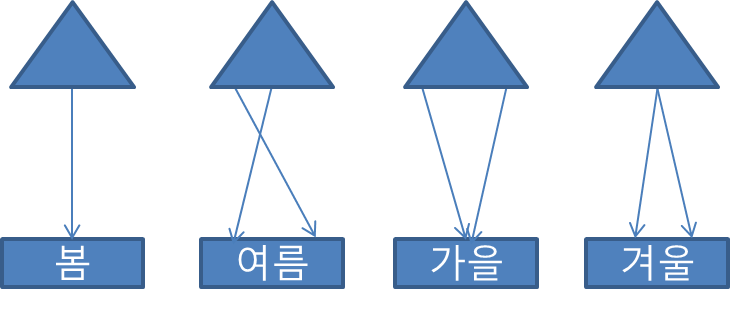

- 글로벌 파티션 인덱스

```sql
-- 인덱스 생성문 마지막에 GLOBAL 옵션을 준 후, 파티션을 생성 로직을 넣으면 글로벌 파티션 인덱스로 생성된다.
create index ... GLOBAL
partition by range(주문금액) (
	partition P_01 values less than (10000)
	, partition P_MX values less than (MAXVALUE)
);
```

  - 테이블 파티션과는 별개로 인덱스의 파티션을 다른 방식으로 만든다.
  - 테이블 파티션이 없어도 생성 가능
  - 테이블 파티션 구성을 변경하는 순간 글로벌 인덱스를 재생성해 줘야 하므로 서비스를 중단해야 함.
  - 아래는 파티션 테이블일 때 글로벌 파티션 인덱스의 예시이다.

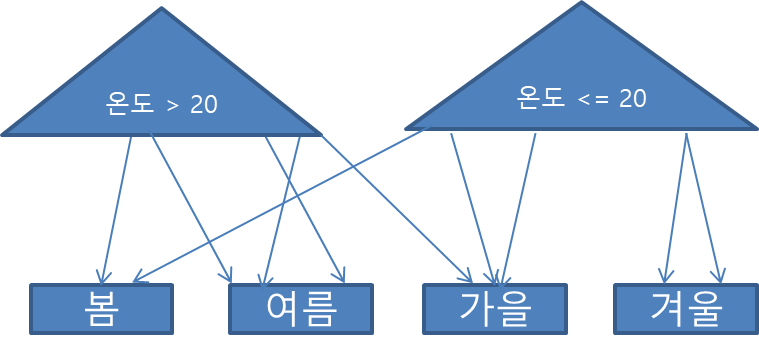

- Prefixed vs Nonprefixed
  - Prefixed : 인덱스 파티션 키 컬럼이 인덱스 컬럼 구성에서 왼쪽 선두에 위치할 경우
  - Nonprefixed : 인덱스 파티션 키 컬럼이 인덱스 컬럼 구성에서 왼쪽 선두에 위치하지 않거나 인덱스 컬럼에 아예 속하지 않는 경우
  - 로컬 Prefixed
    - 테이블 파티션의 키가 '계절'이라면 인덱스 파티션의 키도 '계절'이다.
    - 인덱스의 컬럼 구성을 '계절' + '온도'로 한 로컬 파티션 인덱스를 만들었다면, 파티션 키인 '계절'이 인덱스 컬럼 구성 선두에 위치하므로 이를 로컬 Prefixed라고 한다.
  - 로컬 Nonprefixed
    - 테이블 파티션의 키가 '계절'이라면 인덱스 파티션의 키도 '계절'이다.
    - 인덱스의 컬럼 구성을 '온도'로 한 로컬 파티션 인덱스를 만들었다면, 파티션 키인 '계절'이 인덱스 컬럼에 아예 속하지 않으므로 이를 로컬 Nonprefixed라고 한다.
  - 글로벌 Prefixed
    - 로컬 Prefixed와 설명 동일
  - 글로벌 Nonprefixed
    - 글로벌 파티션 인덱스는 Prefixed 파티션만 지원한다.


- Unique 인덱스를 파티셔닝 하려면, 파티션 키(=테이블 파티션의 키 = 인덱스 파티션의 키)가 모두 인덱스 구성 컬럼이어야 한다. 이는 당연한 제약 사항.
  - 예를 들면 Unique 인덱스가 '주문번호'이고 파티션의 키가 '주문일자'인 로컬 파티션이 존재한다고 가정하자.
  - 인덱스 파티션의 키가 '주문일자'이므로 테이블 파티션도 '주문일자'를 기준으로 파티셔닝이 되어있다.
  - '주문번호'가 1234인 데이터가 들어오게 되면 중복 값이 있는지 확인하기 위해 모든 인덱스의 파티션을 다 확인해야 한다. 왜냐하면 인덱스 파티션의 키는 '주문일자' 이므로 '주문번호'가 1234인 값이 어디에 있는지 알 수가 없기 때문이다.
  - 이렇게 되면 데이터를 Insert 할 때마다 모든 인덱스 파티션을 다 찾아봐야 한다는 게 말이 안 되기 때문에 DBMS 자체에서 당연히 존재하는 제약사항이다.


- 파티션을 활용한 대량 UPDATE 튜닝
  - '인덱스 및 제약 해제를 통한 대량 DML 튜닝'은 해당 DML이 테이블의 데이터를 5% 이상 수정할 경우 사용하는 것을 추천하지만, 테이블의 데이터가 엄청 많다면, 인덱스를 삭제하고 재생성하는 시간도 무시할 수 없으며 약간의 부담이 존재한다.
  - 만약에 테이블이 파티셔닝이 돼 있고, 인덱스 파티션도 로컬 파티션이라면 '인덱스 및 제약 해제를 통한 대량 DML 튜닝' 보다 더 좋은 방법이 있다. 특정 파티션에 대한 임시 세그먼트를 만들어 원본 파티션과 바꿔치기하는 방식이다.

```sql
-- 1. 임시 테이블을 만든다. nologging 모드로 생성하면 더 빠르다.
CREATE TABLE 임시 nologging AS SELECT * FROM 실제테이블 WHERE 1 = 2;

-- 2. 데이터를 수정하고자 하는 데이터를 insert
-- append 힌트로 Direct Path Insert 유도하여 빠르게 insert 하면 좋다.
INSERT /*+ append */ INTO 임시
SELECT 컬럼1, 컬럼2, 컬럼3, (CASE WHEN 데이터변경컬럼 = '1' THEN '2' ELSE '3' END) 데이터변경컬럼
FROM 실제테이블
WHERE 거래일자 < '20210101'; -- 특정 테이블 파티션의 조건으로

-- 3. 임시 테이블에 실제 테이블과 동일하게 인덱스 생성. nologging 모드로 생성하면 더 빠르다.
-- 인덱스를 나중에 만드는 이유는 6.0에서 설명했듯이 DML 성능에 영향을 주기 때문에 나중에 만든다.
CREATE INDEX ...


-- 4. 실제 테이블의 변경하려고 하는 파티션과 임시 테이블을 교체한다.
ALTER TABLE 실제테이블 EXCHANGE PARTITION P202012 WITH TABLE 임시
INCLUDING INDEXES WITHOUT VALIDATION;

-- 5. 임시 테이블 드랍
DROP TABLE 임시;

-- 6. nologging으로 인덱스를 만들었다면 logging으로 전환한다.
```
<br>

- 파티션을 활용한 대량 DELETE 튜닝
  - 전제조건 : 테이블이 파티셔닝이 돼 있고, 인덱스 파티션도 로컬 파티션
  - 파티션에 할당된 데이터를 모두 삭제할 때

```sql
ALTER TABLE 테이블명 DROP PARTITION p201412;​
```

<br>
  - 파티션에 할당된 데이터를 소수만 삭제할 때

```sql
DELETE FROM 테이블명
WHERE 거래일자 < '20210101' -- 파티션 조건
AND 상태 = '1' -- 이외 조건
```
<br>

- 파티션에 할당된 데이터를 대다수 삭제할 때

```sql
-- 1. 임시 테이블을 만드는데 삭제하지 않을 데이터만 남긴다.
-- nologging 모드로 생성하면 더 빠르다.
CREATE TABLE 임시 nologging AS SELECT * FROM 실제테이블 WHERE 거래일자 < '20210101' AND 상태 = '1';

-- 2. 삭제 대상 테이블 파티션을 truncate 한다.
ALTER TABLE 실제테이블 TRUNCATE PARTITION p202012;​

-- 3. 임시 테이블의 데이터를 실제 테이블에 Insert 한다.
INSERT INTO 실제테이블 SELECT * FROM 임시;

-- 4. 임시 테이블 드랍
DROP TABLE 임시;
```
<br>

- 파티션을 활용한 대량 INSERT 튜닝
  - 전제조건 : 테이블이 파티셔닝이 돼 있고, 인덱스 파티션도 로컬 파티션
  - '인덱스 및 제약 해제를 통한 대량 DML 튜닝'과 마찬가지로 파티션 단위로 인덱스 및 제약을 해제하면 된다.

```sql
-- 파티션의 인덱스 비활성화
ALTER INDEX 인덱스명 MODIFY PARTITION P202012 UNUSABLE;

-- 파티션의 인덱스 활성화
ALTER INDEX 인덱스명 REBUILD PARTITION P202012;
```

# **Lock과 트랜잭션 동시성 제어 (오라클 기준)**

- 오라클은 DML, DDL, 래치, 버퍼, 라이브러리 캐시 등 다양한 종류의 Lock을 사용한다.
- 이 중 애플리케이션 개발 측면에서는 DML Lock이 중요하다.


- DML Lock : 다중 트랜잭션이 동시에 액세스 하는 사용자 데이터의 무결성을 보호하기 위한 Lock
  - DML 로우 Lock : 두 개의 동시 트랜잭션이 같은 로우를 변경하는 것을 방지

||select|insert|update|delete|
|--|--|--|--|--|
|로우 LOCK|X|인덱스존재시 O|O|O|

  - DML 테이블 Lock (TM Lock) : 테이블 구조를 다른 트랜잭션이 변경하는 것을 방지
    - 테이블 Lock이라고 해서 테이블 전체에 Lock이 걸리는 의미가 아님.
    - 테이블 Lock에는 여러 가지 모드가 있고, 어떤 모드를 사용했는지에 따라 후행 트랜잭션이 수행할 수 있는 작업의 범위가 결정됨.